In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.special import expit
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Load, Split, and Balance (1.5 points total)
##### **[.5 points]**
* (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric.

In [27]:
#Read in the data
data = pd.read_csv('./acs2017_census_tract_data.csv', low_memory=False)
data.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


* (2) Remove any observations that having missing data.

In [28]:
# data.describe()
#Finding null values
print("Null Values before drop:\n")
print(data.isnull().sum())

data.dropna(axis=0,how="any",inplace=True)

print("\nNull Values after drop:\n")
print(data.isnull().sum())
# data.describe()

Null Values before drop:

TractId                0
State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
dtype: int64

Null Values after drop:

TractId   

* (3) Encode any string data as integers for now.

In [29]:
print("Categorical Features")
print(data.dtypes[data.dtypes != 'float64'][data.dtypes !='int64'])
data_cat = data.copy() # Will be used later
states = data["State"]
counties = data["County"]
data["State"] = data["State"].astype('category')
data["State"] = data["State"].cat.codes
data["County"] = data["County"].astype('category')
data["County"] = data["County"].cat.codes

print("Features After encoding")
print(data.dtypes[data.dtypes != 'float64'][data.dtypes !='int64'])

Categorical Features
State     object
County    object
dtype: object
Features After encoding
State      int8
County    int16
dtype: object


* (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We decided to keep the county data in the dataset instead of trying to take the mean across each state because we determined that there is so much variation between counties that trying to classify them at a state level would lead to a much lower accuracy.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We chose to remove variables such as TractId because it is an ID number and not relevant as a predictor of our classes. We also removed things such as race because we wanted to try to stray away from the model picking up a racial bias and wanted it to focus more on variables such as income and the types of industry in the given county.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We also removed data such as how people commute to work as we determined that this data would not be very important in predicting child poverty as the types of commuting vary drastically and would only really help to determine if a county has most of the population in a city or not and it is not a good indicator as to whether or not a county will have high child poverty. It was also necessary to convert data such as number of Men and number of Women to be percentages so that they were somewhat normalized because without doing this, then a county with a higher population will appear to have more women and men than another county with lower pop. Finally, we removed data about the number of people over the age of 16 who are employed because it is already accounted for in the unemployment rate attribute and by leaving it in, we would create a stronger bias for that data without meaning to.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__NOTE:__ It may be worth while to add this data in back in the end to see if it was increases our accuracy but for now, we will leave it out. 

In [30]:
#Data Cleaning
#Drop Non important columns
data.drop(columns=['TractId','Hispanic','White','Black','Native','Asian','Pacific','Employed','MeanCommute','OtherTransp','Walk','Transit','Carpool','Drive'],inplace=True)


#Numerical Data into percentages so that it is not skewed by population
data['Men'] = data['Men'] / data['TotalPop']
data['Women'] = data['Women'] / data['TotalPop']
data['VotingAgeCitizen'] = data['VotingAgeCitizen'] / data['TotalPop']
data.describe()

,State,County,TotalPop,Men,Women,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,...,Service,Office,Construction,Production,WorkAtHome,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,...,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000,72718.000000
mean,24.340370,998.356941,4443.485121,0.491322,0.508678,0.717249,61119.999326,9690.325642,30666.653222,4249.725969,...,18.847948,23.413165,9.263044,12.922312,4.612646,79.511827,14.149495,6.167661,0.171231,7.224917
std,15.102552,530.254496,2190.183318,0.040244,0.040244,0.104256,30511.062580,6119.407315,15844.127467,2991.009809,...,7.969609,5.591354,5.943849,7.592511,3.770733,7.957350,7.164790,3.798703,0.451630,5.099419
min,0.000000,0.000000,58.000000,0.037275,0.006886,0.083826,2692.000000,728.000000,1631.000000,351.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17.500000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,545.000000,2958.000000,0.469348,0.488619,0.672307,40380.000000,5737.000000,20624.000000,2508.000000,...,13.300000,19.700000,5.000000,7.200000,2.000000,75.300000,9.300000,3.500000,0.000000,3.900000
50%,24.000000,1045.000000,4137.000000,0.490761,0.509239,0.739374,54413.000000,8268.000000,27249.000000,3404.000000,...,17.700000,23.200000,8.400000,11.800000,3.800000,80.600000,13.000000,5.500000,0.000000,6.000000
75%,38.000000,1433.750000,5532.750000,0.511381,0.530652,0.783471,74688.000000,11909.000000,36413.000000,4959.000000,...,23.200000,26.900000,12.500000,17.500000,6.300000,85.000000,17.600000,8.000000,0.000000,9.000000
max,51.000000,1953.000000,65528.000000,0.993114,0.962725,0.992776,249750.000000,153365.000000,220253.000000,84414.000000,...,70.900000,72.300000,68.100000,60.500000,82.800000,100.000000,80.700000,47.400000,22.300000,62.800000


#### Determining the cutoff for our Categories of child poverty
##### [.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We decided to go with pandas built in qcut function which is able to evenly divide any given series into n bins. Since we want 4 types of targets, we gave the function the number 4 for n and it ends up being the cutoff for the quartile ranges of the data. Meaning that the first bin, low child poverty, is the values from the 0th to 25th quartile and the moderate variable is the values from the 25th quartile to the 50th so on and so forth. By doing this, we are left with a roughly equivalent number of entries in each target variable. This is extremely important for the training data because without it, the model could only be good at looking at low poverty rates and would have little data to go off of in the high or extreme categories for example. This idea is not so important for the testing data because when testing, the model should be able to generalize such that it does not need an equivalent number of each class as it is not actively learning from the data and would therefore not be skewed one way or the other. I would argue that it is almost beneficial to have an uneven number of each category in the testing set because that can show if the model is able to generalize well or not.

In [31]:
#Coming up with divisors for child poverty

tmp = pd.qcut(data['ChildPoverty'],4,labels=[1, 2, 3, 4])
# tmp = pd.qcut(data['ChildPoverty'],4,labels=['low','moderate','high','extreme'])
data['ChildPoverty'] = tmp
print(data.groupby(['ChildPoverty']).size())

ChildPoverty
1    18229
2    18171
3    18148
4    18170
dtype: int64


In [54]:
data.columns

Index(['State', 'County', 'TotalPop', 'Men', 'Women', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'WorkAtHome', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment'],
      dtype='object')

##### [.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is NO NEED to split the data multiple times for this lab.

In [32]:
# One-Hot Encodes
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return res


train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f'Train_data shape: {train_data.shape} - {train_data.shape[0] / data.shape[0] * 100:.2f}% of original data')
print('Train_data classes:\n',train_data.groupby(['ChildPoverty']).size()) #Ensure that the number of classes stays relatively equivalent
print(f'\nTest_data shape: {test_data.shape} - {test_data.shape[0] / data.shape[0] * 100:.2f}% of original data')
print('Test_data classes:\n',test_data.groupby(['ChildPoverty']).size())

y_train = pd.DataFrame(train_data['ChildPoverty'])
y_train = y_train.values.ravel()
X_train = train_data.drop(columns=['ChildPoverty'],inplace=False)
# y_train = encode_and_bind(y_train,'ChildPoverty')

y_test = pd.DataFrame(test_data['ChildPoverty'])
y_test = y_test.values.ravel()
X_test = test_data.drop(columns=['ChildPoverty'],inplace=False)
# y_test = encode_and_bind(y_test,'ChildPoverty')


print()
print(f'Type of X: {type(X_train)}\nType of y: {type(y_train)}\n')

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Targets:', np.unique(y_train))
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

Train_data shape: (58174, 23) - 80.00% of original data
Train_data classes:
 ChildPoverty
1    14596
2    14447
3    14538
4    14593
dtype: int64

Test_data shape: (14544, 23) - 20.00% of original data
Test_data classes:
 ChildPoverty
1    3633
2    3724
3    3610
4    3577
dtype: int64

Type of X: <class 'pandas.core.frame.DataFrame'>
Type of y: <class 'numpy.ndarray'>

X_train: (58174, 22)
y_train: (58174,)
Targets: [1 2 3 4]
X_test: (14544, 22)
y_test: (14544,)


## Pre-processing and Initial Modeling (2.5 points total)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will be using a two layer perceptron for the next few parts. The perceptron uses the following properties:
1. Vectorized Gradient Computation - DONE
2. Mini-Batching - TODO
3. Cross Entropy Loss - TODO
4. Proper Glorot Initialization - TODO
5. Sigmoids - DONE

##### Two Layer Perceptron Code

In [8]:
# Two Layer Perceptron Base
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)

        # NOTE: Must add W3 for third layer and so on

        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [9]:
# Add feedforward, fit, predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self

In [10]:
# Vectorized get gradient
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [11]:
# Mini-Batching
class TLPVectorizedMiniBatch(TwoLayerPerceptronVectorized):
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):

            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            
        return self

In [12]:
class TLPVectorizedMiniBatch(TwoLayerPerceptronVectorized):
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):

            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            
        return self

In [13]:
# Cross Entropy Loss


In [14]:
# Proper Glorot Initialization


In [15]:
# If you update the objective function, you must also update the get gradient function

##### **[.5 points]** Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.

In [16]:
#### Mini-Batching NOT Working

# params['epochs'] = 100
# params['eta'] = 0.1
# nn_mini = TLPVectorizedMiniBatch(**params,
#                           alpha=0.1,# momentum calculation
#                           decrease_const=0.1, # decreasing eta
#                           minibatches=len(X_train)/32, # minibatch size
#                           shuffle=True)


# nn_mini.fit(X_train, y_train, print_progress=50)

# # yhat = nn_mini.predict(X_test)
# # print('Accuracy:',accuracy_score(y_test,yhat))

In [33]:
%%time
# ~ 30 s
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, print_progress=50)

yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 400/400

Accuracy: 0.24821232123212322
CPU times: user 1min 33s, sys: 27 s, total: 2min
Wall time: 27.3 s


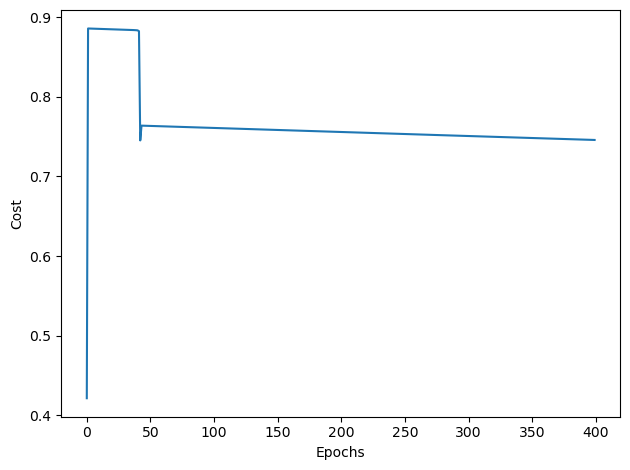

In [34]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

##### **[.5 points]** Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

In [35]:
%%time
# ~ 1 min
# Numerical Columns
cols_to_normalize = ['State', 'County', 'TotalPop', 'Men', 'Women', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
        'Professional', 'Service', 'Office', 'Construction',
       'Production', 'WorkAtHome', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment']

# Copy X_train and X_test
scaler = StandardScaler()
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm[cols_to_normalize] = scaler.fit_transform(X_train_norm[cols_to_normalize])
X_test_norm[cols_to_normalize] = scaler.fit_transform(X_test_norm[cols_to_normalize])

nn_norm = TwoLayerPerceptronVectorized(**params)

nn_norm.fit(X_train_norm, y_train, print_progress=50)

yhat = nn_norm.predict(X_test_norm)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 400/400

Accuracy: 0.25605060506050603
CPU times: user 1min 51s, sys: 34.4 s, total: 2min 25s
Wall time: 39 s


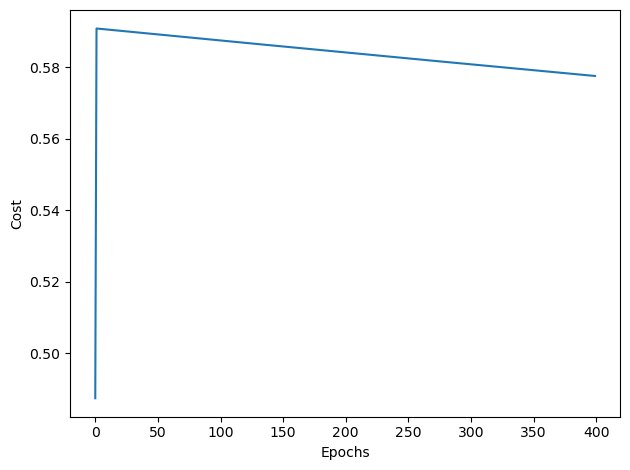

In [36]:
plt.plot(range(len(nn_norm.cost_)), nn_norm.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

##### **[.5 points]** Now (1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Because we need to hot encode the categorical data, we need to go back to the point before we convert the categorical data into numerical. Now that we have the old data, we can go through the pre-processing again and normalize the numerical features and one-hot encode the categorical ones.

In [55]:
scaler = StandardScaler()
cols_to_hot_encode = ['State', 'County']

# Redo Pre-Processing of Data-------------------------------
#Drop Non important columns
data_cat.drop(columns=['TractId','Hispanic','White','Black',
        'Native','Asian','Pacific','Employed','MeanCommute',
        'OtherTransp','Walk','Transit','Carpool','Drive',
        'ChildPoverty'],
        inplace=True)

#Numerical Data into percentages so that it is not skewed by population
data_cat['Men'] = data_cat['Men'] / data_cat['TotalPop']
data_cat['Women'] = data_cat['Women'] / data_cat['TotalPop']
data_cat['VotingAgeCitizen'] = data_cat['VotingAgeCitizen'] / data_cat['TotalPop']

train_data_one_hot, test_data_one_hot = train_test_split(data_cat, test_size=0.2, random_state=42)

y_train_one_hot = pd.DataFrame(train_data['ChildPoverty'])
y_train_one_hot = y_train_one_hot.values.ravel()
X_train_one_hot = train_data_one_hot.drop(columns=['ChildPoverty'],inplace=False)

y_test_one_hot = pd.DataFrame(test_data['ChildPoverty'])
y_test_one_hot = y_test_one_hot.values.ravel()
X_test_one_hot = test_data_one_hot.drop(columns=['ChildPoverty'],inplace=False)

X_train_one_hot[cols_to_normalize] = scaler.fit_transform(X_train_one_hot[cols_to_normalize])
X_test_one_hot[cols_to_normalize] = scaler.fit_transform(X_test_one_hot[cols_to_normalize])
# Redo Pre-Processing of Data-------------------------------

KeyError: "['ChildPoverty'] not found in axis"

In [22]:
# One-Hot Encode Categorical Data
dummies = pd.get_dummies(X_test_one_hot['State'])
res = pd.concat([X_test_one_hot, dummies], axis=1)
X_test_one_hot = res.drop(['State'], axis=1)
dummies = pd.get_dummies(X_test_one_hot['County'])
res = pd.concat([X_test_one_hot, dummies], axis=1)
X_test_one_hot = res.drop(['County'], axis=1)

dummies = pd.get_dummies(X_train_one_hot['State'])
res = pd.concat([X_train_one_hot, dummies], axis=1)
X_train_one_hot = res.drop(['State'], axis=1)
dummies = pd.get_dummies(X_train_one_hot['County'])
res = pd.concat([X_train_one_hot, dummies], axis=1)
X_train_one_hot = res.drop(['County'], axis=1)

In [46]:
%%time
# ~ 12 min
nn_one_hot = TwoLayerPerceptronVectorized(**params)

nn_one_hot.fit(X_train_one_hot, y_train, print_progress=50)

Epoch: 400/400

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1576 is different from 1987)

In [52]:
yhat = nn_one_hot.predict(X_test_one_hot)
print('Accuracy:',accuracy_score(y_test,yhat))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1576 is different from 1987)

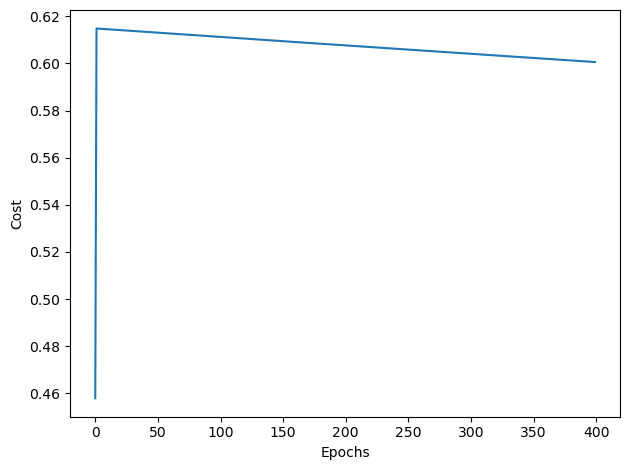

In [41]:
plt.plot(range(len(nn_one_hot.cost_)), nn_one_hot.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

##### **[1 points]** Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The normalized model has a slightly better performance (25.6%) compared to the raw data model (24.8%), because the attributes with higher values have the same weight as the ones with lower values now that they are in the same scale. The improvement is surprinsingly low, and we expected the normalized model to do at least 1.5x better than normal data. The normalized and one-hot encoded model is --- than the other two. This is because machine language models, such as the two layer perceptron implemented above, have a much better time dealing with one-hot encoded attributes than integer encoding as it previously was. However, the one-hot encoding brought the curse of dimensionality, and because of the amount of states and counties, the number of attributes increased to 1500+ and thus the run-time also increased dramastically (about ten-fold).

### Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

### Modeling (5 points total)
##### **[1 points]** Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

##### **[1 points]** Repeat the previous step, adding support for a fourth layer.

##### **[1 points]** Repeat the previous step, adding support for a fifth layer.

##### **[2 points]** Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.

### Exceptional Work (1 points total)
5000 level student: You have free reign to provide additional analyses.
One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance.

In [ ]:
# Data from the notebook just to check that the functions are working and we have the same types for the X and y datasets

from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
X = ds.data/16.0-0.5 # normalize the input, very important
y = ds.target

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

from sklearn.model_selection import train_test_split

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X,y,test_size = 0.2)

print('X_train:', X_train_num.shape)
print('y_train:', y_train_num.shape)
print('X_test:', X_test_num.shape)
print('y_test:', y_test_num.shape)

# nn.fit(X_train_num, y_train_num, print_progress=50)

(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]
X_train: (1437, 64)
y_train: (1437,)
X_test: (360, 64)
y_test: (360,)
